In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('D:/stat_team/project/beers-breweries-and-beer-reviews/reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [5]:
print(df.shape) #원본 데이터 900만개를 사용

(9073128, 10)


In [6]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


In [7]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
uid = df['userid'].values
df['user'] = user_enc.fit_transform(uid.tolist()) #array 인식이 안돼서 list로 빼냄.(userid의 경우만 오류 발생)
n_users = df['user'].nunique()

In [8]:
item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [9]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [10]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [11]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [13]:
beers = pd.read_csv('D:/stat_team/project/beers-breweries-and-beer-reviews/beers.csv')
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [14]:
## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

In [15]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


In [16]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate

Using TensorFlow backend.


## ver1. SGD / relu->sigmoid / batch_size = 1000 / epoch = 10
### test MSE: 0.1887, 과적합 거의X

In [17]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal')(x) #initializer는 정규분포
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV10(n_users, n_beers, n_factors, min_rating, max_rating):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산- activation 2가지를 추가. relu와 sigmoid
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)


    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model = Model(inputs=[user, beer], outputs=x)
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer='sgd') 
    return model

In [18]:
re10model = RecommenderV10(n_users, n_beers, n_factors, min_rating, max_rating)
re10model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        8246750     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        15477100    input_2[0][0]                    
____________________

In [ ]:
## fit model
seed = 7

np.random.seed(seed)
history_mf = re10model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Instructions for updating:
Use tf.cast instead.
Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 2034s 280us/step - loss: 0.3633 - mae: 0.4472 - mse: 0.3633 - val_loss: 0.3344 - val_mae: 0.4294 - val_mse: 0.3344
Epoch 2/10
7258502/7258502 [==============================] - 2039s 281us/step - loss: 0.2900 - mae: 0.3951 - mse: 0.2900 - val_loss: 0.2569 - val_mae: 0.3678 - val_mse: 0.2569
Epoch 3/10
7258502/7258502 [==============================] - 2041s 281us/step - loss: 0.2404 - mae: 0.3534 - mse: 0.2404 - val_loss: 0.2286 - val_mae: 0.3425 - val_mse: 0.2286
Epoch 4/10
7258502/7258502 [==============================] - 2057s 283us/step - loss: 0.2199 - mae: 0.3352 - mse: 0.2199 - val_loss: 0.2144 - val_mae: 0.3304 - val_mse: 0.2144
Epoch 5/10
7258502/7258502 [==============================] - 2221s 306us/step - loss: 0.2083 - mae: 0.3250 - mse: 0.2083 - val_loss: 0.2059 - val_mae: 0.3228 - val_mse: 0.2059
Epoch 6/10
72

In [20]:
## show loss & mae & mse at each epoch
hist10 = pd.DataFrame(history_mf.history)
hist10['epoch'] = history_mf.epoch
hist10

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.334368,0.429426,0.334368,0.363254,0.447196,0.363254,0
1,0.256892,0.367829,0.256892,0.290050,0.395129,0.290050,1
2,0.228589,0.342530,0.228589,0.240372,0.353371,0.240372,2
3,0.214423,0.330433,0.214423,0.219899,0.335200,0.219898,3
4,0.205874,0.322780,0.205874,0.208348,0.324965,0.208347,4
5,0.200111,0.317175,0.200111,0.200734,0.318211,0.200735,5
6,0.196127,0.314513,0.196128,0.195232,0.313319,0.195232,6
7,0.192887,0.310683,0.192888,0.191035,0.309613,0.191034,7
8,0.190601,0.307984,0.190601,0.187698,0.306684,0.187697,8
9,0.188671,0.307476,0.188671,0.184957,0.304285,0.184957,9


In [21]:
#모델 평가하기; model.evaluate()
loss_and_metrics = re10model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 3s 2us/step
## evaluation loss and_metrics ##
[0.18867144932841295, 0.3074757158756256, 0.1886713206768036]


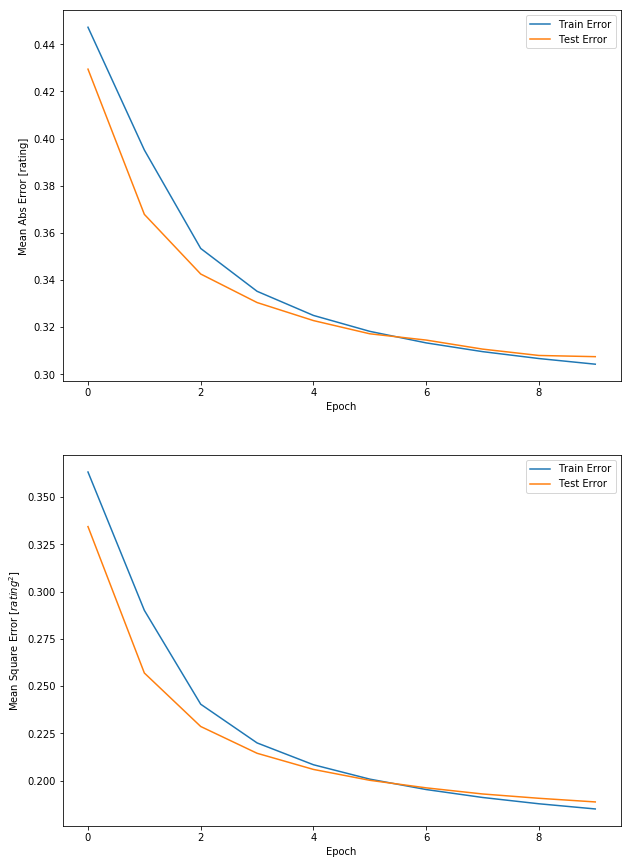

In [22]:
plot_history(hist10)

In [24]:
def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    total_beers = df['beer'].unique().tolist() #모든 beer
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    return unbeers

def recomm_beer_by_keras(userid, model, top_n):
    unbeers = get_unbeer_keras(df,userid)
    predict =[v[0][0] for v in  [model.predict([[userid],[beer]]) for beer in unbeers]]
    ndf= pd.DataFrame({'beer':unbeers,'rating':predict})
    final = ndf.sort_values(by='rating', ascending=False)[:top_n]
    return final


In [25]:
%%time

unbeers = get_unber_keras(df2, 190)
recomm_beer_by_keras(190, re10model, 10)

Wall time: 7min 56s


In [26]:
## get weights of the beers embedding matrix
beer_embedding_weights = re10model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [27]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [28]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([0.16960104, 0.01749058, 0.01745004], dtype=float32)

In [29]:
from operator import itemgetter

## extract first PCA
pca0 = beer_pca.components_[0]

## get the value (pca0, beer title)
beer_comp0 = [(f, beers_dict[i]) for f,i in zip(pca0, list(beers_dict.keys()))]

In [30]:
## beers corresponding to the highest values of pca0
sorted(beer_comp0, key = itemgetter(0), reverse = True)[:10]

[(0.049174562, 'Dirty Bastard - Bourbon-Soaked Apricots And Ginger'),
 (0.047568765, 'Andre the Brut'),
 (0.046691388, 'Bowie'),
 (0.042832155, 'Beelzebub'),
 (0.042322382, 'Stolichnoye Premium'),
 (0.0420493, 'Farmhand Ale'),
 (0.041371975, 'Masham Glory'),
 (0.040644206, 'Pomegranate kolsch'),
 (0.04031844, 'Citrus Haze'),
 (0.039636005, 'Into Your Arms (Bad Seed/Revolutions)')]

In [31]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp0, key = itemgetter(0))[:10]

[(-0.029208867, 'Jolly Golden Ale'),
 (-0.028138148, 'Snowman Make Like A Tree And Leaf Maple Porter'),
 (-0.027175399, "Monk's Phunk"),
 (-0.026290253, 'G-Spot Jalapeno Ale'),
 (-0.025798822, 'Handlebar Hefe'),
 (-0.025600819, 'One-Eyed Jack Imperial Pilsner'),
 (-0.024009727, 'Winter Sesh'),
 (-0.02399198, 'La Grand Duc (Rousse Au Seigle)'),
 (-0.023948234, 'Pecan Porter'),
 (-0.023173459, 'Keisari Lager')]

## 레이어 3개 ver. relu->sigmoid->tanh
### test MSE: 0.1826, 과적합 거의X

In [38]:
def RecommenderV10_2(n_users, n_beers, n_factors, min_rating, max_rating):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산- activation 2가지를 추가. relu와 sigmoid
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    
    x = Dense(5, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('tanh')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)


    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model2 = Model(inputs=[user, beer], outputs=x)
    model2.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer='sgd') 
    return model2

In [39]:
re10model_2 = RecommenderV10_2(n_users, n_beers, n_factors, min_rating, max_rating)
re10model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 50)        8246750     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 50)        15477100    input_8[0][0]                    
____________________________________________________________________________________________

In [40]:
## fit model
seed = 7

np.random.seed(seed)
history_mf_2 = re10model_2.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 2306s 318us/step - loss: 0.3784 - mae: 0.4500 - mse: 0.3784 - val_loss: 0.3381 - val_mae: 0.4329 - val_mse: 0.3381
Epoch 2/10
7258502/7258502 [==============================] - 2090s 288us/step - loss: 0.2766 - mae: 0.3843 - mse: 0.2766 - val_loss: 0.2369 - val_mae: 0.3498 - val_mse: 0.2369
Epoch 3/10
7258502/7258502 [==============================] - 2283s 315us/step - loss: 0.2033 - mae: 0.3210 - mse: 0.2033 - val_loss: 0.1998 - val_mae: 0.3179 - val_mse: 0.1998
Epoch 5/10
7258502/7258502 [==============================] - 2294s 316us/step - loss: 0.1938 - mae: 0.3125 - mse: 0.1938 - val_loss: 0.1936 - val_mae: 0.3130 - val_mse: 0.1936
Epoch 6/10
7258502/7258502 [==============================] - 2218s 306us/step - loss: 0.1877 - mae: 0.3071 - mse: 0.1877 - val_loss: 0.1901 - val_mae: 0.3068 - val_mse: 0.1901
Epoch 7/10
7258502/7258502 [==============================] -

In [41]:
## show loss & mae & mse at each epoch
hist10_2 = pd.DataFrame(history_mf_2.history)
hist10_2['epoch'] = history_mf_2.epoch
hist10_2

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.338093,0.432899,0.338093,0.378389,0.450015,0.378389,0
1,0.236855,0.349789,0.236855,0.276589,0.384346,0.276588,1
2,0.211112,0.328125,0.211112,0.221189,0.336937,0.221189,2
3,0.199759,0.317894,0.199759,0.203302,0.321009,0.203302,3
4,0.193643,0.312985,0.193644,0.193762,0.312504,0.193762,4
5,0.190089,0.306815,0.190089,0.187652,0.307120,0.187651,5
6,0.186829,0.306113,0.186829,0.183324,0.303321,0.183324,6
7,0.184919,0.304868,0.184919,0.180059,0.300507,0.180059,7
8,0.186873,0.302514,0.186873,0.177462,0.298351,0.177462,8
9,0.182634,0.303196,0.182634,0.175295,0.296545,0.175295,9


In [42]:
#모델 평가하기; model.evaluate()
loss_and_metrics_2 = re10model_2.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics_2)

1814626/1814626 [==============================] - 4s 2us/step
## evaluation loss and_metrics ##
[0.18263395534183438, 0.30319613218307495, 0.18263399600982666]


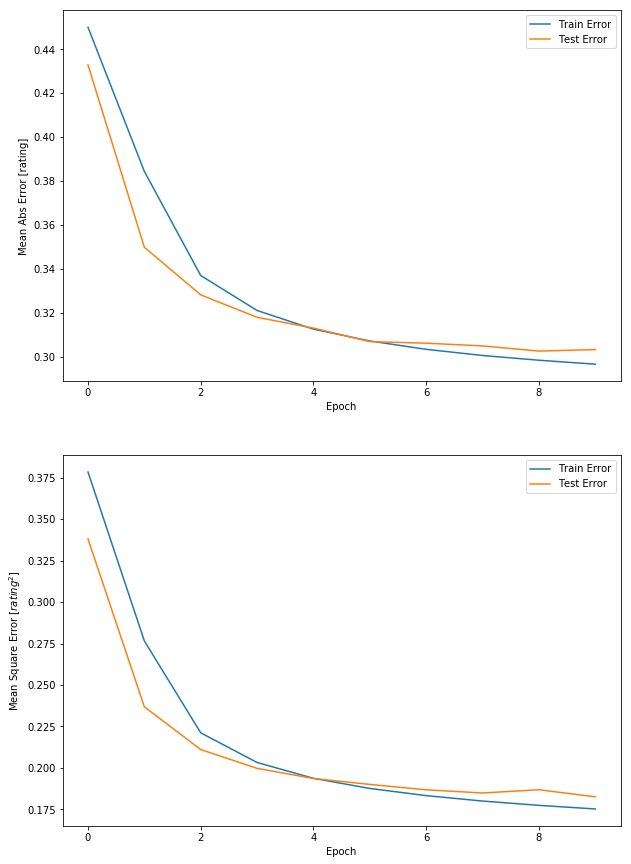

In [43]:
plot_history(hist10_2)

In [45]:
%%time

unbeers = get_unbeer_keras(df2, 190)
recomm_beer_by_keras(190, re10model_2, 10)

Wall time: 4min 5s


In [46]:
## get weights of the beers embedding matrix
beer_embedding_weights_2 = re10model_2.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights_2.shape

(309542, 50)

In [47]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t_2 = np.transpose(beer_embedding_weights_2) ## pass the transpose of the embedding matrix
beer_pca_2 = pca.fit(beer_embedding_weights_t_2) ## fit

## display the resulting matrix dimensions
beer_pca_2.components_.shape

(3, 309542)

In [48]:
## display the variance explained by the 3 components
beer_pca_2.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([0.13203485, 0.01831605, 0.01824323], dtype=float32)

In [49]:
from operator import itemgetter

## extract first PCA
pca0_2 = beer_pca_2.components_[0]

## get the value (pca0, beer title)
beer_comp0_2 = [(f, beers_dict[i]) for f,i in zip(pca0_2, list(beers_dict.keys()))]

In [50]:
## beers corresponding to the highest values of pca0
sorted(beer_comp0_2, key = itemgetter(0), reverse = True)[:10]

[(0.050681207, 'Andre the Brut'),
 (0.04674414, 'Your Highnessness'),
 (0.046098664, 'Masham Glory'),
 (0.04417234, 'Beelzebub'),
 (0.04413581, 'Stout Impérial Russe Cognac'),
 (0.043625068, 'Dirty Bastard - Bourbon-Soaked Apricots And Ginger'),
 (0.043154884, 'Into Your Arms (Bad Seed/Revolutions)'),
 (0.042700335, 'Bowie'),
 (0.04159756, 'Permanent Midnight (imperial Porter)'),
 (0.040935446, 'Oryza IPA')]

In [51]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp0_2, key = itemgetter(0))[:10]

[(-0.023869595, 'Snowman Make Like A Tree And Leaf Maple Porter'),
 (-0.019873738, 'Jolly Golden Ale'),
 (-0.019427963, "Monk's Phunk"),
 (-0.018188877, 'Saison Garni'),
 (-0.017338948, 'Hop De Mensenge'),
 (-0.016595302, 'Full Rosenberry'),
 (-0.016522815, 'Buckeye Beer'),
 (-0.016335417, 'Vormann Pils'),
 (-0.016322868, 'Always In Life'),
 (-0.0160915, 'La Grand Duc (Rousse Au Seigle)')]